In [ ]:
import os

import keras

print("Keras = {}".format(keras.__version__))
import tensorflow as tf

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # or any {'0', '1', '2'}
import matplotlib.pyplot as plt
import numpy as np
from keras.preprocessing.image import ImageDataGenerator
from keras.models import load_model
import seaborn as sns
import pandas as pd


# Print gpus
gpus = tf.config.experimental.list_physical_devices('GPU')
print("Num GPUs Available: ", len(gpus))

# model_dir = './models/'
model_file = 'vit_brain_mri.keras'

Keras = 2.15.0
Num GPUs Available:  1


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
! unzip -o /content/drive/MyDrive/dataset_19.zip

! pwd

Archive:  /content/drive/MyDrive/dataset_19.zip
   creating: dataset_19/glioma/
  inflating: dataset_19/glioma/Te-gl_0010.jpg  
  inflating: dataset_19/glioma/Te-gl_0016.jpg  
  inflating: dataset_19/glioma/Te-gl_0020.jpg  
  inflating: dataset_19/glioma/Te-gl_0026.jpg  
  inflating: dataset_19/glioma/Te-gl_0035.jpg  
  inflating: dataset_19/glioma/Te-gl_0041.jpg  
  inflating: dataset_19/glioma/Te-gl_0043.jpg  
  inflating: dataset_19/glioma/Te-gl_0044.jpg  
  inflating: dataset_19/glioma/Te-gl_0045.jpg  
  inflating: dataset_19/glioma/Te-gl_0057.jpg  
  inflating: dataset_19/glioma/Te-gl_0060.jpg  
  inflating: dataset_19/glioma/Te-gl_0075.jpg  
  inflating: dataset_19/glioma/Te-gl_0079.jpg  
  inflating: dataset_19/glioma/Te-gl_0085.jpg  
  inflating: dataset_19/glioma/Te-gl_0090.jpg  
  inflating: dataset_19/glioma/Te-gl_0107.jpg  
  inflating: dataset_19/glioma/Te-gl_0114.jpg  
  inflating: dataset_19/glioma/Te-gl_0125.jpg  
  inflating: dataset_19/glioma/Te-gl_0126.jpg  
  inflat

# Load the Data

In [ ]:
# Data Directories
dir = "dataset_19/"
validation_dir = "Testing"

# Data Distribution

In [ ]:
data_distribution_count = pd.Series(
    {curr_index: len(os.listdir(os.path.join(dir, curr_index))) for curr_index in os.listdir(dir)})

data_distribution_count

pituitary     120
meningioma    120
glioma        120
notumor       120
dtype: int64

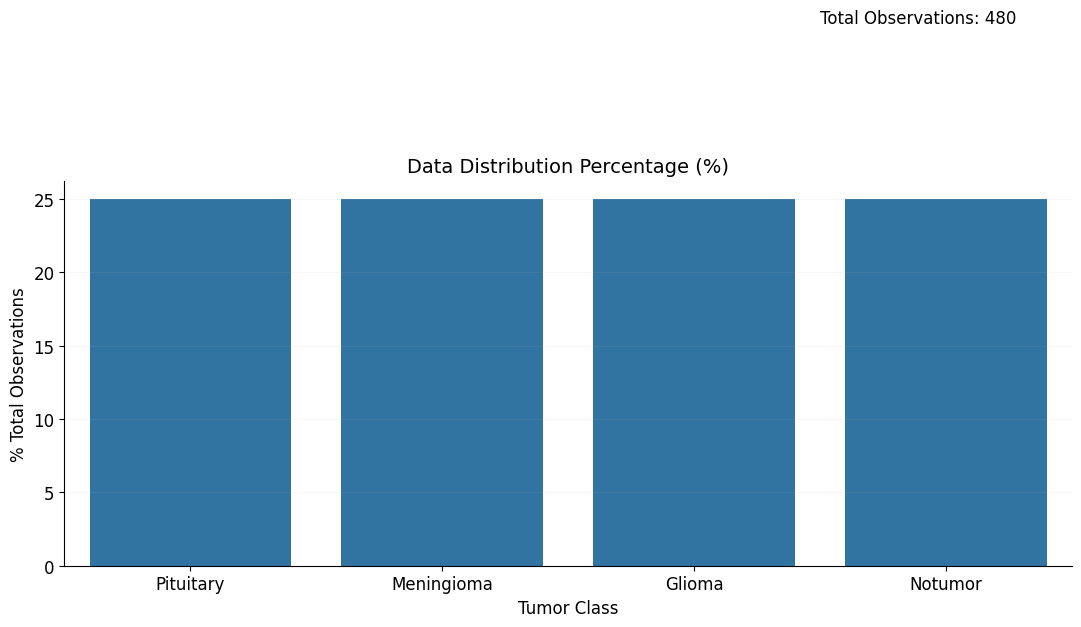

In [ ]:
fig, axis = plt.subplots(figsize=(13, 5))
axis.grid(True, alpha=0.1)
axis.set_title("Data Distribution Percentage (%)", fontsize=14)
sns.barplot(x=['\n'.join(curr_index.strip().split('_')).title() for curr_index in data_distribution_count.index],
            y=100 * data_distribution_count / data_distribution_count.sum(), ax=axis)
axis.set_xlabel("Tumor Class", fontsize=12)
axis.set_ylabel("% Total Observations", fontsize=12)
axis.tick_params(which='major', labelsize=12)
axis.text(2.5, 37, f'Total Observations: {data_distribution_count.sum()}', fontdict=dict(size=12))
sns.despine()

# Preprocess the Data

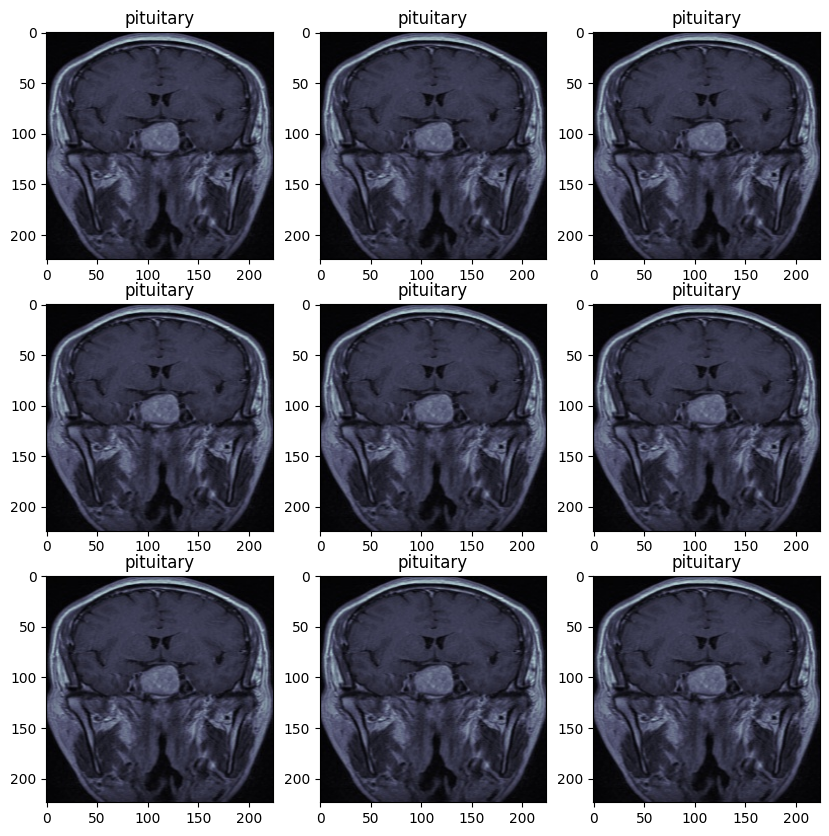

In [ ]:
from tqdm import tqdm
import cv2
import imutils

def crop_img(img):

  # Find extreme points on the image and crop the rectangular out

  gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
  gray = cv2.GaussianBlur(gray, (3, 3), 0)

  # threshold the image, then perform a series of erosions +
  # dilations to remove any small regions of noise
  thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
  thresh = cv2.erode(thresh, None, iterations=2)
  thresh = cv2.dilate(thresh, None, iterations=2)

  # find contours in thresholded image, then grab the largest one
  cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
  cnts = imutils.grab_contours(cnts)
  c = max(cnts, key=cv2.contourArea)

  # find the extreme points
  extLeft = tuple(c[c[:, :, 0].argmin()][0])
  extRight = tuple(c[c[:, :, 0].argmax()][0])
  extTop = tuple(c[c[:, :, 1].argmin()][0])
  extBot = tuple(c[c[:, :, 1].argmax()][0])
  ADD_PIXELS = 0
  new_img = img[extTop[1]-ADD_PIXELS:extBot[1]+ADD_PIXELS, extLeft[0]-ADD_PIXELS:extRight[0]+ADD_PIXELS].copy()

  return new_img

def preprocess_images(directory):
    for dir in os.listdir(directory):
        path = os.path.join(directory, dir)
        for img_name in os.listdir(path):
            img_path = os.path.join(path, img_name)
            img = cv2.imread(img_path)
            cropped_img = crop_img(img)
            processed_img = cv2.cvtColor(cropped_img, cv2.COLOR_RGB2GRAY)
            processed_img = cv2.bilateralFilter(processed_img, 2, 50, 50)
            processed_img = cv2.applyColorMap(processed_img, cv2.COLORMAP_BONE)
            processed_img = cv2.resize(processed_img, (224, 224))
            cv2.imwrite(img_path, processed_img)


# Preprocess the images before generating data
preprocess_images(dir)

# Display 9 image using matplotlib
plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    for curr_index in os.listdir(dir):
        path = os.path.join(dir, curr_index)
        for img_name in os.listdir(path):
            img_path = os.path.join(path, img_name)
            image = plt.imread(img_path)
            plt.imshow(image)
            plt.title(curr_index)
            break
        break

# Splitting the Data

Found 384 images belonging to 4 classes.
Found 96 images belonging to 4 classes.
{'glioma': 0, 'meningioma': 1, 'notumor': 2, 'pituitary': 3}


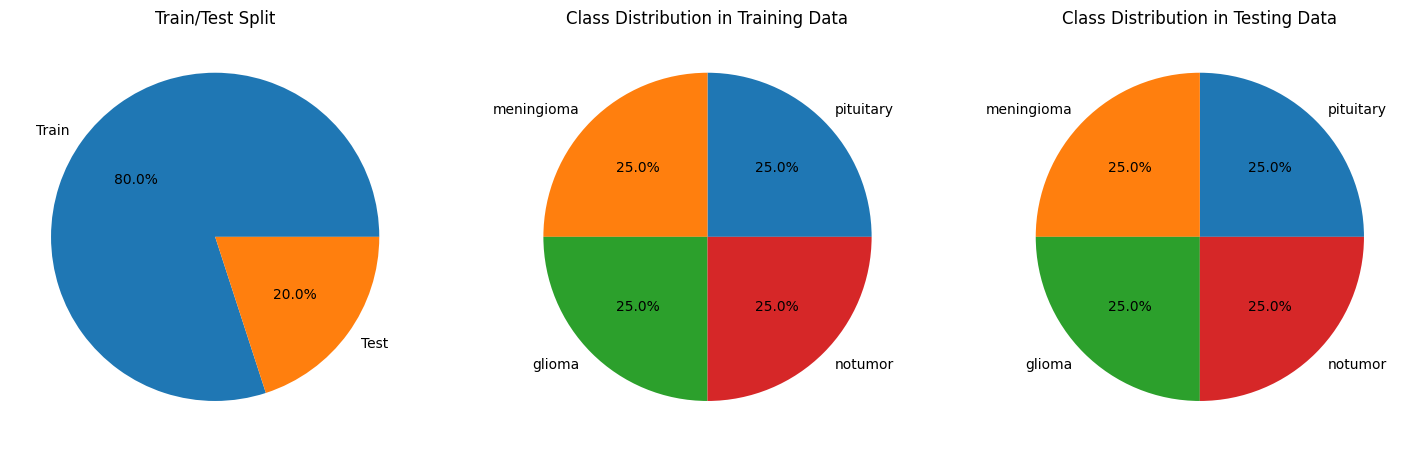

In [ ]:
classes = os.listdir(dir)
batch_size = 10

train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    rotation_range=20,
    width_shift_range=0.05,
    height_shift_range=0.05,
    horizontal_flip=True,
    validation_split=0.2)

validation_datagen = ImageDataGenerator(rescale=1. / 255,
                                        validation_split=0.2)

train_generator = train_datagen.flow_from_directory(
    dir,
    target_size=(224, 224),
    batch_size=batch_size,
    seed=42,
    subset='training'
)

test_generator = validation_datagen.flow_from_directory(
    dir,
    target_size=(224, 224),
    batch_size=batch_size,
    seed=42,
    subset='validation',
    shuffle=False)


print(test_generator.class_indices)

# Get the number of samples in the training and testing data
num_train_samples = train_generator.samples
num_test_samples = test_generator.samples

# Get the distribution of classes in the training and testing data
train_class_distribution = np.bincount(train_generator.classes)
test_class_distribution = np.bincount(test_generator.classes)

# Create a figure with 3 subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Plot the train/test split
axes[0].pie([num_train_samples, num_test_samples], labels=['Train', 'Test'], autopct='%1.1f%%')
axes[0].set_title('Train/Test Split')

# Plot the distribution of classes in the training data
axes[1].pie(train_class_distribution, labels=classes, autopct='%1.1f%%')
axes[1].set_title('Class Distribution in Training Data')

# Plot the distribution of classes in the testing data
axes[2].pie(test_class_distribution, labels=classes, autopct='%1.1f%%')
axes[2].set_title('Class Distribution in Testing Data')

# Display the plots
plt.show()

# To Check Data Loading and Augmentation


In [ ]:
print(train_generator.class_indices)
print(test_generator.class_indices)

{'glioma': 0, 'meningioma': 1, 'notumor': 2, 'pituitary': 3}
{'glioma': 0, 'meningioma': 1, 'notumor': 2, 'pituitary': 3}


# Installing TensorFlow Addon and vit-keras Package

In [ ]:
! pip install tensorflow-addons vit-keras
! pip install optuna

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 7.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.0/40.0 kB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.1/380.1 kB 6.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.4/233.4 kB 9.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 9.5 MB/s eta 0:00:00


# Training a Vision Transformer (ViT) model



In [ ]:
from transformers import ViTForImageClassification, ViTConfig, ViTModel
from tensorflow.keras.layers import Input, Dropout, Dense
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from vit_keras import vit, layers
from sklearn.utils.class_weight import compute_class_weight
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import optuna
from tensorflow.keras.regularizers import l2


# # Function to create ViT model
# def create_vit_model(input_shape, num_classes, learning_rate, dropout_rate, l2_reg):
#     vit_model = vit.vit_b16(
#         image_size=224,
#         pretrained=True,
#         include_top=True,
#         pretrained_top=False,
#         classes=num_classes
#     )

#     inputs = Input(shape=input_shape, dtype=tf.float32)
#     outputs = vit_model(inputs)
#     outputs = Dropout(dropout_rate)(outputs)  # Use variable dropout rate
#     outputs = tf.keras.layers.Dense(num_classes, activation='softmax', kernel_regularizer=l2(l2_reg))(outputs)
#     model = Model(inputs, outputs)
#     model = Model(inputs, outputs)
#     model.compile(optimizer=Adam(learning_rate=learning_rate),  # Use variable learning rate
#                   loss=CategoricalCrossentropy(from_logits=True),
#                   metrics=['accuracy'])
#     return model


## *** BETTER LEARNING CURVE BUT BAD CM ***

# def create_vit_model(input_shape, num_classes, learning_rate, dropout_rate, l2_reg):
#     # Load the pretrained ViT model
#     vit_model = vit.vit_b16(
#         image_size=224,
#         activation='softmax',
#         pretrained=True,
#         include_top=False,
#         pretrained_top=False,
#         classes=num_classes
#     )

#     # Freeze the pretrained layers
#     for layer in vit_model.layers:
#         layer.trainable = False  # Freezing the layer

#     # Create new input layer
#     inputs = Input(shape=input_shape, dtype=tf.float32)
#     # Pass inputs through the ViT model
#     x = vit_model(inputs)

#     # Add new layers
#     x = Dropout(dropout_rate)(x)  # Use variable dropout rate
#     x = Dense(num_classes, activation='softmax', kernel_regularizer=tf.keras.regularizers.l2(l2_reg))(x)

#     # Create the final model
#     model = Model(inputs=inputs, outputs=x)
#     model.compile(optimizer=Adam(learning_rate=learning_rate),
#                   loss=CategoricalCrossentropy(from_logits=True),
#                   metrics=['accuracy'])
#     return model

# Function to create ViT model
def create_vit_model(input_shape, num_classes, learning_rate, dropout_rate):
    vit_model = vit.vit_b16(
        image_size=224,
        activation='softmax',
        pretrained=True,
        include_top=False,
        pretrained_top=False,
        classes=num_classes
    )

    # Unfreeze the top layers of the pretrained ViT model
    for layer in vit_model.layers[-3:]:  # Unfreeze the last 3 layers, adjust as needed
        layer.trainable = True

    inputs = Input(shape=input_shape, dtype=tf.float32)
    x = vit_model(inputs)
    x = Dropout(dropout_rate)(x)
    outputs = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer=Adam(learning_rate=learning_rate),
                  loss=CategoricalCrossentropy(from_logits=True),
                  metrics=['accuracy'])
    return model

# Define the objective function for Optuna
def objective(trial):
    learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-3)
    dropout_rate = trial.suggest_uniform('dropout_rate', 0.3, 0.5)

    model = create_vit_model((224, 224, 3), len(classes), learning_rate, dropout_rate)

    checkpoint = ModelCheckpoint(model_file, monitor='val_loss', verbose=1, save_best_only=True)
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1, mode='auto')  # Reduced patience
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)  # Reduced patience

    class_weights = compute_class_weight('balanced', classes=np.unique(train_generator.classes), y=train_generator.classes)
    class_weights = {i: class_weights[i] for i in range(len(class_weights))}

    # Run fewer epochs for initial trials
    initial_epochs = 15

    history = model.fit(
        train_generator,
        steps_per_epoch=train_generator.samples // train_generator.batch_size,
        epochs=initial_epochs,
        validation_data=test_generator,
        validation_steps=test_generator.samples // test_generator.batch_size,
        callbacks=[checkpoint, early_stopping, reduce_lr],
        class_weight=class_weights
    )

    model.load_weights(model_file)
    trial.set_user_attr('history', history.history)
    val_loss = model.evaluate(test_generator, steps=test_generator.samples // batch_size, verbose=0)[0]

    return val_loss

# Run Optuna optimization with fewer epochs
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=10)

# Best trial results
print('Best trial:')
trial = study.best_trial
print(f'  Value: {trial.value}')
print('  Params: ')
for key, value in trial.params.items():
    print(f'    {key}: {value}')

history = trial.user_attrs['history']

/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(
[I 2024-06-12 06:34:49,335] A new study created in memory with name: no-name-f5e23eac-2d65-4cf9-bec5-f3b23d37266e
<ipython-input-11-23dce8f45330>:97: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-3)
<ipython-input-11-23dce8f45330>:98: FutureWarning: sugge

347502902/347502902 [==============================] - 1s 0us/step


/usr/local/lib/python3.10/dist-packages/vit_keras/utils.py:81: UserWarning: Resizing position embeddings from 24, 24 to 14, 14
  warnings.warn(


Epoch 1/15


/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:5575: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


38/38 [==============================] - ETA: 0s - loss: 1.4030 - accuracy: 0.4733
Epoch 1: val_loss improved from inf to 1.66347, saving model to vit_brain_mri.keras
38/38 [==============================] - 58s 406ms/step - loss: 1.4030 - accuracy: 0.4733 - val_loss: 1.6635 - val_accuracy: 0.5222 - lr: 1.2963e-04
Epoch 2/15
38/38 [==============================] - ETA: 0s - loss: 0.6951 - accuracy: 0.7406
Epoch 2: val_loss improved from 1.66347 to 0.81118, saving model to vit_brain_mri.keras
38/38 [==============================] - 12s 311ms/step - loss: 0.6951 - accuracy: 0.7406 - val_loss: 0.8112 - val_accuracy: 0.7778 - lr: 1.2963e-04
Epoch 3/15
38/38 [==============================] - ETA: 0s - loss: 0.4000 - accuracy: 0.8743
Epoch 3: val_loss improved from 0.81118 to 0.33259, saving model to vit_brain_mri.keras
38/38 [==============================] - 12s 310ms/step - loss: 0.4000 - accuracy: 0.8743 - val_loss: 0.3326 - val_accuracy: 0.9000 - lr: 1.2963e-04
Epoch 4/15
38/38 [====

[I 2024-06-12 06:41:55,751] Trial 0 finished with value: 0.33259230852127075 and parameters: {'learning_rate': 0.0001296286768675528, 'dropout_rate': 0.46539105153080834}. Best is trial 0 with value: 0.33259230852127075.
<ipython-input-11-23dce8f45330>:97: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-3)
<ipython-input-11-23dce8f45330>:98: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.3, 0.5)
/usr/local/lib/python3.10/dist-packages/vit_keras/utils.py:81: UserWarning: Resizing position embeddings from 24, 24 to 14, 14
  warnings.warn(


Epoch 1/15


/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:5575: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


38/38 [==============================] - ETA: 0s - loss: 1.7866 - accuracy: 0.3369
Epoch 1: val_loss improved from inf to 0.93917, saving model to vit_brain_mri.keras
38/38 [==============================] - 53s 386ms/step - loss: 1.7866 - accuracy: 0.3369 - val_loss: 0.9392 - val_accuracy: 0.6222 - lr: 1.1405e-05
Epoch 2/15
38/38 [==============================] - ETA: 0s - loss: 1.2993 - accuracy: 0.4920
Epoch 2: val_loss improved from 0.93917 to 0.89732, saving model to vit_brain_mri.keras
38/38 [==============================] - 12s 308ms/step - loss: 1.2993 - accuracy: 0.4920 - val_loss: 0.8973 - val_accuracy: 0.6111 - lr: 1.1405e-05
Epoch 3/15
38/38 [==============================] - ETA: 0s - loss: 0.9883 - accuracy: 0.6211
Epoch 3: val_loss improved from 0.89732 to 0.63524, saving model to vit_brain_mri.keras
38/38 [==============================] - 12s 314ms/step - loss: 0.9883 - accuracy: 0.6211 - val_loss: 0.6352 - val_accuracy: 0.7444 - lr: 1.1405e-05
Epoch 4/15
38/38 [====

[I 2024-06-12 06:49:54,074] Trial 1 finished with value: 0.46404269337654114 and parameters: {'learning_rate': 1.1404778179768013e-05, 'dropout_rate': 0.468814738245904}. Best is trial 0 with value: 0.33259230852127075.
<ipython-input-11-23dce8f45330>:97: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-3)
<ipython-input-11-23dce8f45330>:98: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.3, 0.5)
/usr/local/lib/python3.10/dist-packages/vit_keras/utils.py:81: UserWarning: Resizing position embeddings from 24, 24 to 14, 14
  warnings.warn(


Epoch 1/15


/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:5575: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


38/38 [==============================] - ETA: 0s - loss: 1.5718 - accuracy: 0.3904
Epoch 1: val_loss improved from inf to 0.94244, saving model to vit_brain_mri.keras
38/38 [==============================] - 53s 380ms/step - loss: 1.5718 - accuracy: 0.3904 - val_loss: 0.9424 - val_accuracy: 0.6333 - lr: 1.6510e-04
Epoch 2/15
38/38 [==============================] - ETA: 0s - loss: 0.7552 - accuracy: 0.7299
Epoch 2: val_loss improved from 0.94244 to 0.90463, saving model to vit_brain_mri.keras
38/38 [==============================] - 12s 305ms/step - loss: 0.7552 - accuracy: 0.7299 - val_loss: 0.9046 - val_accuracy: 0.7000 - lr: 1.6510e-04
Epoch 3/15
38/38 [==============================] - ETA: 0s - loss: 0.6836 - accuracy: 0.7620
Epoch 3: val_loss improved from 0.90463 to 0.75750, saving model to vit_brain_mri.keras
38/38 [==============================] - 12s 304ms/step - loss: 0.6836 - accuracy: 0.7620 - val_loss: 0.7575 - val_accuracy: 0.8222 - lr: 1.6510e-04
Epoch 4/15
38/38 [====

[I 2024-06-12 06:58:06,555] Trial 2 finished with value: 0.32972168922424316 and parameters: {'learning_rate': 0.00016510227853356837, 'dropout_rate': 0.32691942273982233}. Best is trial 2 with value: 0.32972168922424316.
<ipython-input-11-23dce8f45330>:97: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-3)
<ipython-input-11-23dce8f45330>:98: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.3, 0.5)
/usr/local/lib/python3.10/dist-packages/vit_keras/utils.py:81: UserWarning: Resizing position embeddings from 24, 24 to 14, 14
  warnings.warn(


Epoch 1/15


/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:5575: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


38/38 [==============================] - ETA: 0s - loss: 1.8549 - accuracy: 0.3824
Epoch 1: val_loss improved from inf to 0.99491, saving model to vit_brain_mri.keras
38/38 [==============================] - 53s 386ms/step - loss: 1.8549 - accuracy: 0.3824 - val_loss: 0.9949 - val_accuracy: 0.5667 - lr: 3.0319e-04
Epoch 2/15
38/38 [==============================] - ETA: 0s - loss: 1.0234 - accuracy: 0.5775
Epoch 2: val_loss improved from 0.99491 to 0.51137, saving model to vit_brain_mri.keras
38/38 [==============================] - 12s 306ms/step - loss: 1.0234 - accuracy: 0.5775 - val_loss: 0.5114 - val_accuracy: 0.8000 - lr: 3.0319e-04
Epoch 3/15
38/38 [==============================] - ETA: 0s - loss: 0.6521 - accuracy: 0.7553
Epoch 3: val_loss improved from 0.51137 to 0.31228, saving model to vit_brain_mri.keras
38/38 [==============================] - 12s 310ms/step - loss: 0.6521 - accuracy: 0.7553 - val_loss: 0.3123 - val_accuracy: 0.8889 - lr: 3.0319e-04
Epoch 4/15
38/38 [====

[I 2024-06-12 07:05:06,387] Trial 3 finished with value: 0.31228107213974 and parameters: {'learning_rate': 0.0003031866483874665, 'dropout_rate': 0.39562199570277046}. Best is trial 3 with value: 0.31228107213974.
<ipython-input-11-23dce8f45330>:97: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-3)
<ipython-input-11-23dce8f45330>:98: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.3, 0.5)
/usr/local/lib/python3.10/dist-packages/vit_keras/utils.py:81: UserWarning: Resizing position embeddings from 24, 24 to 14, 14
  warnings.warn(


Epoch 1/15


/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:5575: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


38/38 [==============================] - ETA: 0s - loss: 1.0935 - accuracy: 0.5829
Epoch 1: val_loss improved from inf to 0.54134, saving model to vit_brain_mri.keras
38/38 [==============================] - 52s 380ms/step - loss: 1.0935 - accuracy: 0.5829 - val_loss: 0.5413 - val_accuracy: 0.8111 - lr: 1.1071e-04
Epoch 2/15
38/38 [==============================] - ETA: 0s - loss: 0.5947 - accuracy: 0.8075
Epoch 2: val_loss did not improve from 0.54134
38/38 [==============================] - 8s 207ms/step - loss: 0.5947 - accuracy: 0.8075 - val_loss: 0.8059 - val_accuracy: 0.7889 - lr: 1.1071e-04
Epoch 3/15
38/38 [==============================] - ETA: 0s - loss: 0.3113 - accuracy: 0.9037
Epoch 3: val_loss improved from 0.54134 to 0.29250, saving model to vit_brain_mri.keras
38/38 [==============================] - 12s 305ms/step - loss: 0.3113 - accuracy: 0.9037 - val_loss: 0.2925 - val_accuracy: 0.8889 - lr: 1.1071e-04
Epoch 4/15
38/38 [==============================] - ETA: 0s - lo

[I 2024-06-12 07:12:03,308] Trial 4 finished with value: 0.29249951243400574 and parameters: {'learning_rate': 0.0001107117449413457, 'dropout_rate': 0.3391265705752909}. Best is trial 4 with value: 0.29249951243400574.
<ipython-input-11-23dce8f45330>:97: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-3)
<ipython-input-11-23dce8f45330>:98: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.3, 0.5)
/usr/local/lib/python3.10/dist-packages/vit_keras/utils.py:81: UserWarning: Resizing position embeddings from 24, 24 to 14, 14
  warnings.warn(


Epoch 1/15


/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:5575: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


38/38 [==============================] - ETA: 0s - loss: 1.7230 - accuracy: 0.2674
Epoch 1: val_loss improved from inf to 1.40095, saving model to vit_brain_mri.keras
38/38 [==============================] - 54s 379ms/step - loss: 1.7230 - accuracy: 0.2674 - val_loss: 1.4010 - val_accuracy: 0.2667 - lr: 8.4104e-04
Epoch 2/15
38/38 [==============================] - ETA: 0s - loss: 1.4367 - accuracy: 0.2620
Epoch 2: val_loss improved from 1.40095 to 1.32589, saving model to vit_brain_mri.keras
38/38 [==============================] - 12s 304ms/step - loss: 1.4367 - accuracy: 0.2620 - val_loss: 1.3259 - val_accuracy: 0.3778 - lr: 8.4104e-04
Epoch 3/15
38/38 [==============================] - ETA: 0s - loss: 1.3268 - accuracy: 0.3447
Epoch 3: val_loss improved from 1.32589 to 1.06053, saving model to vit_brain_mri.keras
38/38 [==============================] - 12s 307ms/step - loss: 1.3268 - accuracy: 0.3447 - val_loss: 1.0605 - val_accuracy: 0.4222 - lr: 8.4104e-04
Epoch 4/15
38/38 [====

[I 2024-06-12 07:20:15,097] Trial 5 finished with value: 0.9400918483734131 and parameters: {'learning_rate': 0.0008410390836443475, 'dropout_rate': 0.41756195573248206}. Best is trial 4 with value: 0.29249951243400574.
<ipython-input-11-23dce8f45330>:97: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-3)
<ipython-input-11-23dce8f45330>:98: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.3, 0.5)
/usr/local/lib/python3.10/dist-packages/vit_keras/utils.py:81: UserWarning: Resizing position embeddings from 24, 24 to 14, 14
  warnings.warn(


Epoch 1/15


/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:5575: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


38/38 [==============================] - ETA: 0s - loss: 1.0970 - accuracy: 0.5882
Epoch 1: val_loss improved from inf to 0.71948, saving model to vit_brain_mri.keras
38/38 [==============================] - 54s 384ms/step - loss: 1.0970 - accuracy: 0.5882 - val_loss: 0.7195 - val_accuracy: 0.7333 - lr: 6.0742e-05
Epoch 2/15
38/38 [==============================] - ETA: 0s - loss: 0.4750 - accuracy: 0.8209
Epoch 2: val_loss improved from 0.71948 to 0.59038, saving model to vit_brain_mri.keras
38/38 [==============================] - 12s 305ms/step - loss: 0.4750 - accuracy: 0.8209 - val_loss: 0.5904 - val_accuracy: 0.7778 - lr: 6.0742e-05
Epoch 3/15
38/38 [==============================] - ETA: 0s - loss: 0.3239 - accuracy: 0.8797
Epoch 3: val_loss improved from 0.59038 to 0.53766, saving model to vit_brain_mri.keras
38/38 [==============================] - 12s 306ms/step - loss: 0.3239 - accuracy: 0.8797 - val_loss: 0.5377 - val_accuracy: 0.8222 - lr: 6.0742e-05
Epoch 4/15
38/38 [====

[I 2024-06-12 07:28:02,545] Trial 6 finished with value: 0.4160626232624054 and parameters: {'learning_rate': 6.0742076808781485e-05, 'dropout_rate': 0.3893973051838014}. Best is trial 4 with value: 0.29249951243400574.
<ipython-input-11-23dce8f45330>:97: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-3)
<ipython-input-11-23dce8f45330>:98: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.3, 0.5)
/usr/local/lib/python3.10/dist-packages/vit_keras/utils.py:81: UserWarning: Resizing position embeddings from 24, 24 to 14, 14
  warnings.warn(


Epoch 1/15


/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:5575: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


38/38 [==============================] - ETA: 0s - loss: 1.4548 - accuracy: 0.4920
Epoch 1: val_loss improved from inf to 0.89423, saving model to vit_brain_mri.keras
38/38 [==============================] - 52s 379ms/step - loss: 1.4548 - accuracy: 0.4920 - val_loss: 0.8942 - val_accuracy: 0.6222 - lr: 4.0482e-05
Epoch 2/15
38/38 [==============================] - ETA: 0s - loss: 0.8234 - accuracy: 0.6925
Epoch 2: val_loss improved from 0.89423 to 0.88092, saving model to vit_brain_mri.keras
38/38 [==============================] - 12s 304ms/step - loss: 0.8234 - accuracy: 0.6925 - val_loss: 0.8809 - val_accuracy: 0.7222 - lr: 4.0482e-05
Epoch 3/15
38/38 [==============================] - ETA: 0s - loss: 0.5112 - accuracy: 0.8048
Epoch 3: val_loss improved from 0.88092 to 0.63507, saving model to vit_brain_mri.keras
38/38 [==============================] - 12s 307ms/step - loss: 0.5112 - accuracy: 0.8048 - val_loss: 0.6351 - val_accuracy: 0.7556 - lr: 4.0482e-05
Epoch 4/15
38/38 [====

[I 2024-06-12 07:35:39,936] Trial 7 finished with value: 0.5087445378303528 and parameters: {'learning_rate': 4.048182339097214e-05, 'dropout_rate': 0.49022196203662266}. Best is trial 4 with value: 0.29249951243400574.
<ipython-input-11-23dce8f45330>:97: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-3)
<ipython-input-11-23dce8f45330>:98: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.3, 0.5)
/usr/local/lib/python3.10/dist-packages/vit_keras/utils.py:81: UserWarning: Resizing position embeddings from 24, 24 to 14, 14
  warnings.warn(


Epoch 1/15


/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:5575: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


38/38 [==============================] - ETA: 0s - loss: 1.3934 - accuracy: 0.4759
Epoch 1: val_loss improved from inf to 1.03380, saving model to vit_brain_mri.keras
38/38 [==============================] - 54s 382ms/step - loss: 1.3934 - accuracy: 0.4759 - val_loss: 1.0338 - val_accuracy: 0.6778 - lr: 3.1004e-05
Epoch 2/15
38/38 [==============================] - ETA: 0s - loss: 0.7010 - accuracy: 0.7273
Epoch 2: val_loss improved from 1.03380 to 0.79544, saving model to vit_brain_mri.keras
38/38 [==============================] - 12s 305ms/step - loss: 0.7010 - accuracy: 0.7273 - val_loss: 0.7954 - val_accuracy: 0.7222 - lr: 3.1004e-05
Epoch 3/15
38/38 [==============================] - ETA: 0s - loss: 0.4244 - accuracy: 0.8396
Epoch 3: val_loss improved from 0.79544 to 0.56100, saving model to vit_brain_mri.keras
38/38 [==============================] - 12s 306ms/step - loss: 0.4244 - accuracy: 0.8396 - val_loss: 0.5610 - val_accuracy: 0.8000 - lr: 3.1004e-05
Epoch 4/15
38/38 [====

[I 2024-06-12 07:43:44,075] Trial 8 finished with value: 0.33071690797805786 and parameters: {'learning_rate': 3.1004062593119676e-05, 'dropout_rate': 0.40920991548969093}. Best is trial 4 with value: 0.29249951243400574.
<ipython-input-11-23dce8f45330>:97: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-3)
<ipython-input-11-23dce8f45330>:98: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.3, 0.5)
/usr/local/lib/python3.10/dist-packages/vit_keras/utils.py:81: UserWarning: Resizing position embeddings from 24, 24 to 14, 14
  warnings.warn(


Epoch 1/15


/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:5575: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


38/38 [==============================] - ETA: 0s - loss: 1.1838 - accuracy: 0.5294
Epoch 1: val_loss improved from inf to 0.77111, saving model to vit_brain_mri.keras
38/38 [==============================] - 52s 379ms/step - loss: 1.1838 - accuracy: 0.5294 - val_loss: 0.7711 - val_accuracy: 0.7111 - lr: 3.9174e-05
Epoch 2/15
38/38 [==============================] - ETA: 0s - loss: 0.5888 - accuracy: 0.7647
Epoch 2: val_loss improved from 0.77111 to 0.61335, saving model to vit_brain_mri.keras
38/38 [==============================] - 12s 304ms/step - loss: 0.5888 - accuracy: 0.7647 - val_loss: 0.6134 - val_accuracy: 0.7000 - lr: 3.9174e-05
Epoch 3/15
38/38 [==============================] - ETA: 0s - loss: 0.3898 - accuracy: 0.8583
Epoch 3: val_loss improved from 0.61335 to 0.60633, saving model to vit_brain_mri.keras
38/38 [==============================] - 12s 305ms/step - loss: 0.3898 - accuracy: 0.8583 - val_loss: 0.6063 - val_accuracy: 0.8000 - lr: 3.9174e-05
Epoch 4/15
38/38 [====

[I 2024-06-12 07:51:05,530] Trial 9 finished with value: 0.4088023006916046 and parameters: {'learning_rate': 3.917446860048594e-05, 'dropout_rate': 0.3633100174713732}. Best is trial 4 with value: 0.29249951243400574.


Best trial:
  Value: 0.29249951243400574
  Params: 
    learning_rate: 0.0001107117449413457
    dropout_rate: 0.3391265705752909


In [ ]:
# Extract best hyperparameters
best_learning_rate = trial.params['learning_rate']
best_dropout_rate = trial.params['dropout_rate']

# Calculate class weights
class_weights = compute_class_weight('balanced', classes=np.unique(train_generator.classes), y=train_generator.classes)
class_weights = {i: class_weights[i] for i in range(len(class_weights))}

# Create and compile the model with the best hyperparameters
model = create_vit_model((224, 224, 3), len(classes), best_learning_rate, best_dropout_rate)

/usr/local/lib/python3.10/dist-packages/vit_keras/utils.py:81: UserWarning: Resizing position embeddings from 24, 24 to 14, 14
  warnings.warn(


In [ ]:
checkpoint = ModelCheckpoint(model_file, monitor='val_loss', verbose=1, save_best_only=True)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='auto')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=7, min_lr=1e-6)

history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=50,
    validation_data=test_generator,
    validation_steps=test_generator.samples // test_generator.batch_size,
    callbacks=[checkpoint, early_stopping, reduce_lr],
    class_weight=class_weights
)

# Save the model
model.save(model_file)

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:5575: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


38/38 [==============================] - ETA: 0s - loss: 1.2209 - accuracy: 0.5455
Epoch 1: val_loss improved from inf to 0.65540, saving model to vit_brain_mri.keras
38/38 [==============================] - 55s 382ms/step - loss: 1.2209 - accuracy: 0.5455 - val_loss: 0.6554 - val_accuracy: 0.7222 - lr: 1.1071e-04
Epoch 2/50
38/38 [==============================] - ETA: 0s - loss: 0.5832 - accuracy: 0.7567
Epoch 2: val_loss did not improve from 0.65540
38/38 [==============================] - 8s 206ms/step - loss: 0.5832 - accuracy: 0.7567 - val_loss: 1.0424 - val_accuracy: 0.7222 - lr: 1.1071e-04
Epoch 3/50
38/38 [==============================] - ETA: 0s - loss: 0.4451 - accuracy: 0.8503
Epoch 3: val_loss improved from 0.65540 to 0.60052, saving model to vit_brain_mri.keras
38/38 [==============================] - 12s 307ms/step - loss: 0.4451 - accuracy: 0.8503 - val_loss: 0.6005 - val_accuracy: 0.8222 - lr: 1.1071e-04
Epoch 4/50
38/38 [==============================] - ETA: 0s - lo

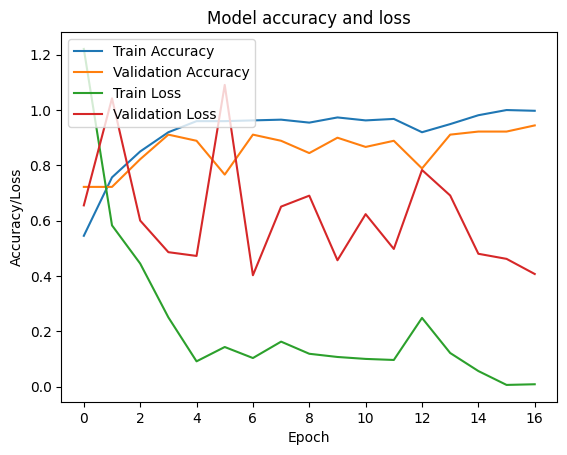

In [ ]:
# Learning curve
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

# Loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('Model accuracy and loss')
plt.ylabel('Accuracy/Loss')
plt.xlabel('Epoch')
plt.legend(['Train Accuracy', 'Validation Accuracy', 'Train Loss', 'Validation Loss'], loc='upper left')
plt.show()

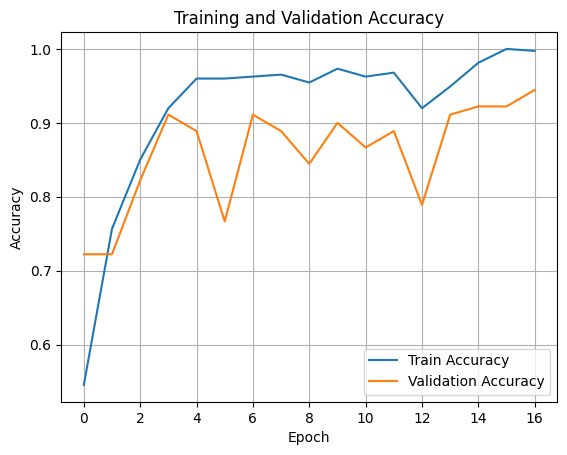

In [ ]:
# Plotting training and validation accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')  # Plot training accuracy
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')  # Plot validation accuracy
plt.title('Training and Validation Accuracy')  # Title of the plot
plt.xlabel('Epoch')  # X-axis label
plt.ylabel('Accuracy')  # Y-axis label
plt.legend()  # Add a legend to specify which line is which
plt.grid(True)  # Add grid for better readability
plt.show()  # Display the plot

**Model Visualisation (Evaluation)**

10/10 [==============================] - 3s 67ms/step


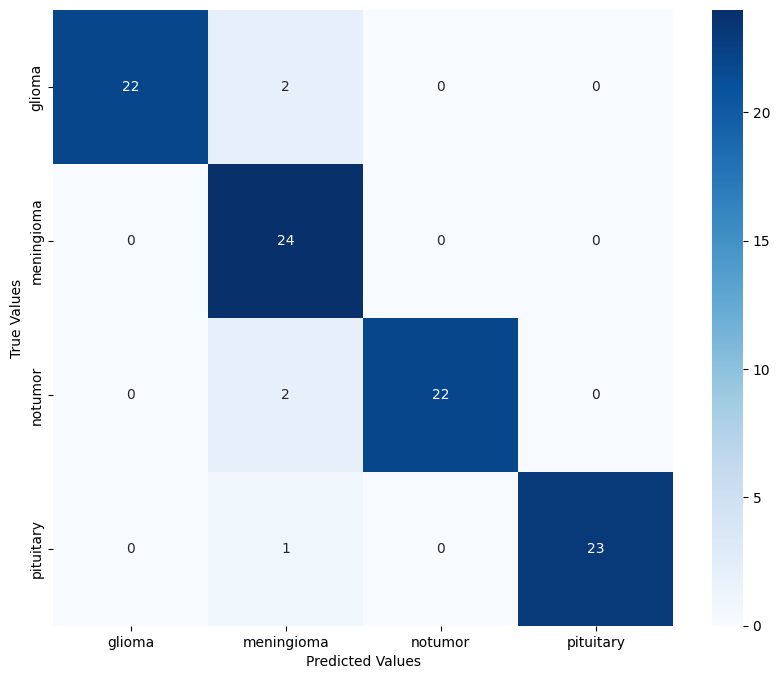

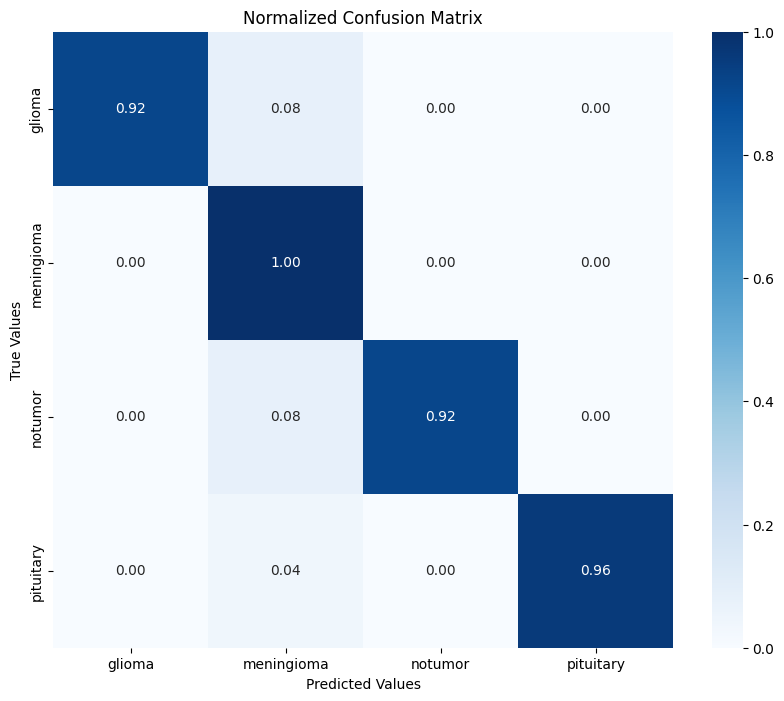

DSC: 0.9493568149686699, Sensitivity: 0.9479166666666666, Specificity: 0.9826388888888888, Accuracy: 0.9479166666666666


In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score

classes = ['glioma', 'meningioma', 'notumor', 'pituitary']

def calculate_metrics(y_true, y_pred):
    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Plot the Confusion Matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted Values')
    plt.ylabel('True Values')
    plt.show()

    # Normalize the confusion matrix
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    # Plot the normalized confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted Values')
    plt.ylabel('True Values')
    plt.title('Normalized Confusion Matrix')
    plt.show()

    # Calculate metrics for each class and average them
    dsc = np.mean([2.0 * cm[i, i] / (np.sum(cm[i, :]) + np.sum(cm[:, i])) for i in range(cm.shape[0])])
    sensitivity = np.mean([cm[i, i] / np.sum(cm[i, :]) for i in range(cm.shape[0])])
    specificity = np.mean([np.sum(np.delete(np.delete(cm, j, 0), j, 1)) / np.sum(np.delete(cm, j, 0)) for j in range(cm.shape[0])])

    # Accuracy
    accuracy = accuracy_score(y_true, y_pred)

    return dsc, sensitivity, specificity, accuracy

# Predict the output
predictions_prob = model.predict(test_generator)
predictions = np.argmax(predictions_prob, axis=1)

dsc, sensitivity, specificity, accuracy = calculate_metrics(test_generator.classes, predictions)
print(f"DSC: {dsc}, Sensitivity: {sensitivity}, Specificity: {specificity}, Accuracy: {accuracy}")


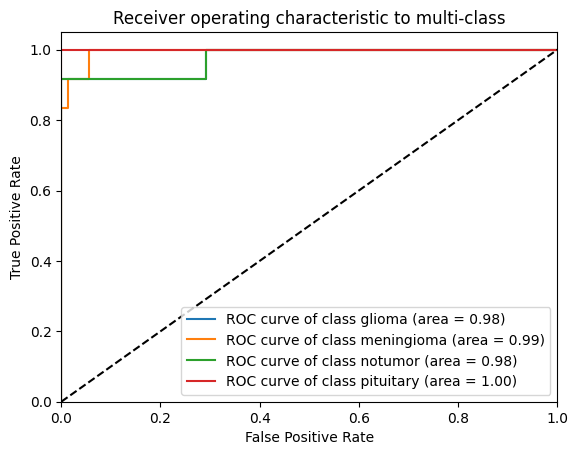

              precision    recall  f1-score   support

      glioma       1.00      0.92      0.96        24
  meningioma       0.83      1.00      0.91        24
     notumor       1.00      0.92      0.96        24
   pituitary       1.00      0.96      0.98        24

   micro avg       0.95      0.95      0.95        96
   macro avg       0.96      0.95      0.95        96
weighted avg       0.96      0.95      0.95        96
 samples avg       0.95      0.95      0.95        96



In [ ]:
from sklearn.metrics import roc_curve, auc, classification_report
from sklearn.preprocessing import LabelBinarizer
import matplotlib.pyplot as plt
import numpy as np

# Binarize the output
lb = LabelBinarizer()
y_test = lb.fit_transform(test_generator.classes)
y_pred = lb.transform(predictions)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(len(classes)):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], predictions_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure()
for i, class_name in enumerate(classes):
    plt.plot(fpr[i], tpr[i],
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(class_name, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()

# Print classification report
print(classification_report(y_test, y_pred, target_names=classes))

# K-Folds Validation

In [ ]:
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow import keras
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping

# Set parameters
dir = 'dataset_19'  # Update this to your dataset directory
batch_size = 10
input_shape = (224, 224, 3)
num_classes = 4
learning_rate = best_learning_rate
dropout_rate = best_dropout_rate
k = 7

# Prepare data generators
datagen = ImageDataGenerator(
    rescale=1. / 255,
    horizontal_flip=True,
    rotation_range=20
)

# List all images and labels
all_images = []
all_labels = []

for class_index, class_name in enumerate(os.listdir(dir)):
    class_dir = os.path.join(dir, class_name)
    for image_name in os.listdir(class_dir):
        all_images.append(os.path.join(class_dir, image_name))
        all_labels.append(str(class_index))  # Convert class index to string

# Convert lists to numpy arrays
all_images = np.array(all_images)
all_labels = np.array(all_labels)

# Define K-Fold cross-validation
kf = KFold(n_splits=k, shuffle=True, random_state=42)

# Initialize lists to store metrics
fold_accuracies = []
fold_losses = []

# Iterate over each fold
for fold, (train_index, val_index) in enumerate(kf.split(all_images)):
    print(f'Fold {fold + 1}/{k}')

    train_images, val_images = all_images[train_index], all_images[val_index]
    train_labels, val_labels = all_labels[train_index], all_labels[val_index]

    # Create DataFrames for training and validation data
    train_df = pd.DataFrame({'filename': train_images, 'class': train_labels})
    val_df = pd.DataFrame({'filename': val_images, 'class': val_labels})

    # Create training and validation data generators
    train_generator = datagen.flow_from_dataframe(
        dataframe=train_df,
        x_col='filename',
        y_col='class',
        target_size=(224, 224),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=True
    )

    validation_generator = datagen.flow_from_dataframe(
        dataframe=val_df,
        x_col='filename',
        y_col='class',
        target_size=(224, 224),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False
    )

    # Define the ViT Model
    model = create_vit_model(input_shape, num_classes, learning_rate, dropout_rate)

    # Compile the model
    optimizer = keras.optimizers.Adam(learning_rate)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

    # Callbacks
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', patience=10, factor=0.3, min_lr=1e-6, verbose=1)
    # checkpoint = ModelCheckpoint(f'model_fold_{fold + 1}.h5', monitor='val_loss', verbose=1, save_best_only=True)
    early_stopping = EarlyStopping(monitor='val_loss', patience=15, verbose=1, mode='auto')

    # Train the model
    history = model.fit(
        train_generator,
        steps_per_epoch=train_generator.samples // train_generator.batch_size,
        epochs=20,
        validation_data=validation_generator,
        validation_steps=validation_generator.samples // validation_generator.batch_size,
        callbacks=[early_stopping, reduce_lr]
    )

    # Store the best validation accuracy and loss for the current fold
    best_val_accuracy = max(history.history['val_accuracy'])
    best_val_loss = min(history.history['val_loss'])
    fold_accuracies.append(best_val_accuracy)
    fold_losses.append(best_val_loss)

# Calculate mean and standard deviation of accuracies and losses
mean_accuracy = np.mean(fold_accuracies)
std_accuracy = np.std(fold_accuracies)
mean_loss = np.mean(fold_losses)
std_loss = np.std(fold_losses)

print(f'Validation Accuracy: {mean_accuracy:.4f} ± {std_accuracy:.4f}')
print(f'Validation Loss: {mean_loss:.4f} ± {std_loss:.4f}')

Fold 1/7
Found 411 validated image filenames belonging to 4 classes.
Found 69 validated image filenames belonging to 4 classes.


/usr/local/lib/python3.10/dist-packages/vit_keras/utils.py:81: UserWarning: Resizing position embeddings from 24, 24 to 14, 14
  warnings.warn(


Epoch 1/20


ResourceExhaustedError: Graph execution error:

Detected at node model_19/vit-b16/Transformer/encoderblock_6/MlpBlock_3/lambda/Gelu/Erf defined at (most recent call last):
  File "/usr/lib/python3.10/runpy.py", line 196, in _run_module_as_main

  File "/usr/lib/python3.10/runpy.py", line 86, in _run_code

  File "/usr/local/lib/python3.10/dist-packages/colab_kernel_launcher.py", line 37, in <module>

  File "/usr/local/lib/python3.10/dist-packages/traitlets/config/application.py", line 992, in launch_instance

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelapp.py", line 619, in start

  File "/usr/local/lib/python3.10/dist-packages/tornado/platform/asyncio.py", line 195, in start

  File "/usr/lib/python3.10/asyncio/base_events.py", line 603, in run_forever

  File "/usr/lib/python3.10/asyncio/base_events.py", line 1909, in _run_once

  File "/usr/lib/python3.10/asyncio/events.py", line 80, in _run

  File "/usr/local/lib/python3.10/dist-packages/tornado/ioloop.py", line 685, in <lambda>

  File "/usr/local/lib/python3.10/dist-packages/tornado/ioloop.py", line 738, in _run_callback

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 825, in inner

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 786, in run

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 361, in process_one

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 261, in dispatch_shell

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 539, in execute_request

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py", line 302, in do_execute

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/zmqshell.py", line 539, in run_cell

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 2975, in run_cell

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3030, in _run_cell

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/async_helpers.py", line 78, in _pseudo_sync_runner

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3257, in run_cell_async

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3473, in run_ast_nodes

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code

  File "<ipython-input-23-afe642831058>", line 91, in <cell line: 47>

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1807, in fit

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1401, in train_function

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1384, in step_function

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1373, in run_step

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1150, in train_step

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 590, in __call__

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/base_layer.py", line 1149, in __call__

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 96, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py", line 515, in call

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py", line 672, in _run_internal_graph

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 590, in __call__

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/base_layer.py", line 1149, in __call__

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 96, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py", line 515, in call

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py", line 672, in _run_internal_graph

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/base_layer.py", line 1149, in __call__

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 96, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/vit_keras/layers.py", line 173, in call

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 590, in __call__

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/base_layer.py", line 1149, in __call__

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 96, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/sequential.py", line 398, in call

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py", line 515, in call

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py", line 672, in _run_internal_graph

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/base_layer.py", line 1149, in __call__

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 96, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/lambda_layer.py", line 212, in call

  File "/usr/local/lib/python3.10/dist-packages/vit_keras/layers.py", line 147, in <lambda>

  File "/usr/local/lib/python3.10/dist-packages/keras/src/activations.py", line 348, in gelu

failed to allocate memory
	 [[{{node model_19/vit-b16/Transformer/encoderblock_6/MlpBlock_3/lambda/Gelu/Erf}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_train_function_993587]

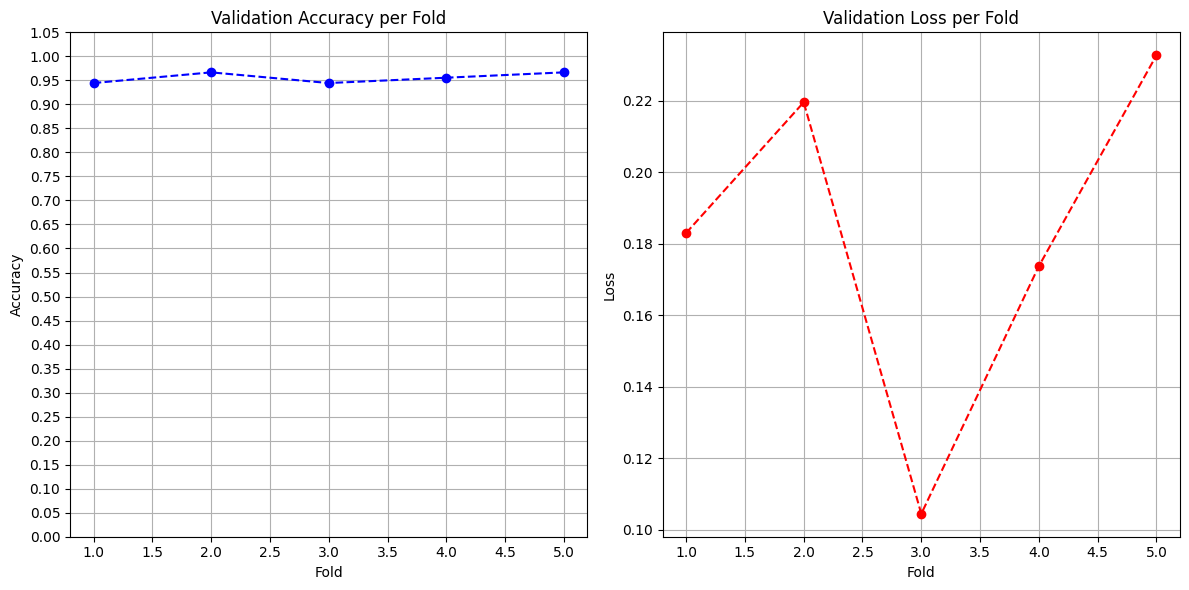

In [ ]:

import matplotlib.pyplot as plt

# Plot validation accuracies
plt.figure(figsize=(12, 6))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(range(1, k + 1), fold_accuracies, marker='o', linestyle='--', color='b')
plt.title('Validation Accuracy per Fold')
plt.xlabel('Fold')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.yticks(np.arange(0, 1.1, 0.05))
plt.grid(True)

# Loss
plt.subplot(1, 2, 2)
plt.plot(range(1, k + 1), fold_losses, marker='o', linestyle='--', color='r')
plt.title('Validation Loss per Fold')
plt.xlabel('Fold')
plt.ylabel('Loss')
plt.grid(True)

# Show plots
plt.tight_layout()
plt.show()